In [1]:
from pathlib import Path

import torch
import pandas as pd
import seaborn as sns
import numpy as np
import shap

from captum.attr import DeepLiftShap
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

from src.models import load_model
from src.loaders import DataLoader
from src.utils.loaders import load_variable
from src.utils.loaders import load_x, load_y
from src.metrics import Accuracy, Precision, Recall, F1

In [2]:
config_path = Path("configs/main/config.py")
dataset_path = Path(".data")
plots = dataset_path / "evaluations/plots"
exp_path = Path(".data/models/resnet18")
experiment_path = Path(".data/models/resnet18/723")
top_losses_path = experiment_path / "evaluations/top_losses/reports/top_losses.csv"

In [3]:
config = load_variable("config", config_path)
model = load_model(config, experiment_path / "checkpoints/epoch=17.ckpt")
_, _, test_loader = DataLoader.get_loaders(path_to_data=dataset_path, config=config)

targets = torch.cat([y for _, y in test_loader])
preds = model(torch.cat([x for x, _ in test_loader]))

flat_targets = targets.argmax(dim=1)
flat_preds = preds.argmax(dim=1)


Applying test preprocessors ...: 100%|██████████| 1/1 [00:00<00:00, 337.27it/s]
2021-03-27 23:33:44,442 WARNING d:\Programowanie\NeuralNetwork\src\models\resnet_blocks.py:411 - Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
print(round(Accuracy()(preds, flat_targets), 4))
print(round(Precision()(preds, flat_targets), 4))
print(round(Recall()(preds, flat_targets), 4))
print(round(F1()(preds, flat_targets), 4))

0.936
0.936
0.9364
0.9362


In [5]:
confusion_matrix(flat_targets, flat_preds)

array([[747,   1,   1,   1],
       [  1, 739,   0,  10],
       [  0,   1, 651,  98],
       [  1,  15,  63, 671]], dtype=int64)

In [6]:
metrics = pd.read_csv(experiment_path / "metrics/metrics_all.csv")
metrics_all = pd.read_csv(experiment_path / "metrics/metrics_group_all.csv")
metrics_group_last = pd.read_csv(experiment_path / "metrics/metrics_group_last.csv")
top_losses = pd.read_csv(top_losses_path)

In [7]:
many_metrics = metrics

for i in [721, 722, 724, 725]:
    path = exp_path / f"{i}/metrics/metrics_all.csv"
    current = pd.read_csv(path)
    many_metrics = pd.concat([many_metrics, current])

many_metrics = many_metrics[many_metrics["epoch"] < 41]

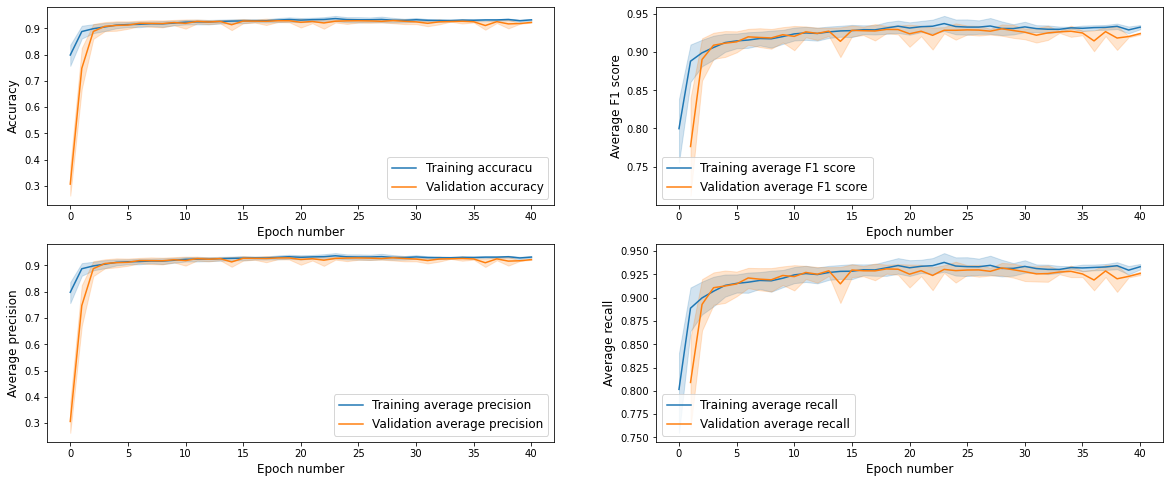

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))


sns.lineplot(data=many_metrics, x="epoch", y="accuracy", ax=axes[0][0], estimator=np.mean, ci=95, label="Training accuracu")
sns.lineplot(data=many_metrics, x="epoch", y="val_accuracy", ax=axes[0][0], estimator=np.mean, ci=95, label="Validation accuracy")
axes[0][0].set_ylabel("Accuracy", fontsize=12)
axes[0][0].set_xlabel("Epoch number", fontsize=12)
axes[0][0].legend(loc="best", prop={'size': 12})

sns.lineplot(data=many_metrics, x="epoch", y="f1_score", ax=axes[0][1], estimator=np.mean, ci=95, label="Training average F1 score")
sns.lineplot(data=many_metrics, x="epoch", y="val_f1_score", ax=axes[0][1], estimator=np.mean, ci=95, label="Validation average F1 score")
axes[0][1].set_ylabel("Average F1 score", fontsize=12)
axes[0][1].set_xlabel("Epoch number", fontsize=12)
axes[0][1].legend(loc="best", prop={'size': 12})


sns.lineplot(data=many_metrics, x="epoch", y="precision", ax=axes[1][0], estimator=np.mean, ci=95, label="Training average precision")
sns.lineplot(data=many_metrics, x="epoch", y="val_precision", ax=axes[1][0], estimator=np.mean, ci=95, label="Validation average precision")
axes[1][0].set_ylabel("Average precision", fontsize=12)
axes[1][0].set_xlabel("Epoch number", fontsize=12)
axes[1][0].legend(loc="best", prop={'size': 12})

sns.lineplot(data=many_metrics, x="epoch", y="recall", ax=axes[1][1], estimator=np.mean, ci=95, label="Training average recall")
sns.lineplot(data=many_metrics, x="epoch", y="val_recall", ax=axes[1][1], estimator=np.mean, ci=95, label="Validation average recall")
axes[1][1].set_ylabel("Average recall", fontsize=12)
axes[1][1].set_xlabel("Epoch number", fontsize=12)
axes[1][1].legend(loc="best", prop={'size': 12})

plt.savefig(plots / "metrics.png", transparent=True, dpi=500)


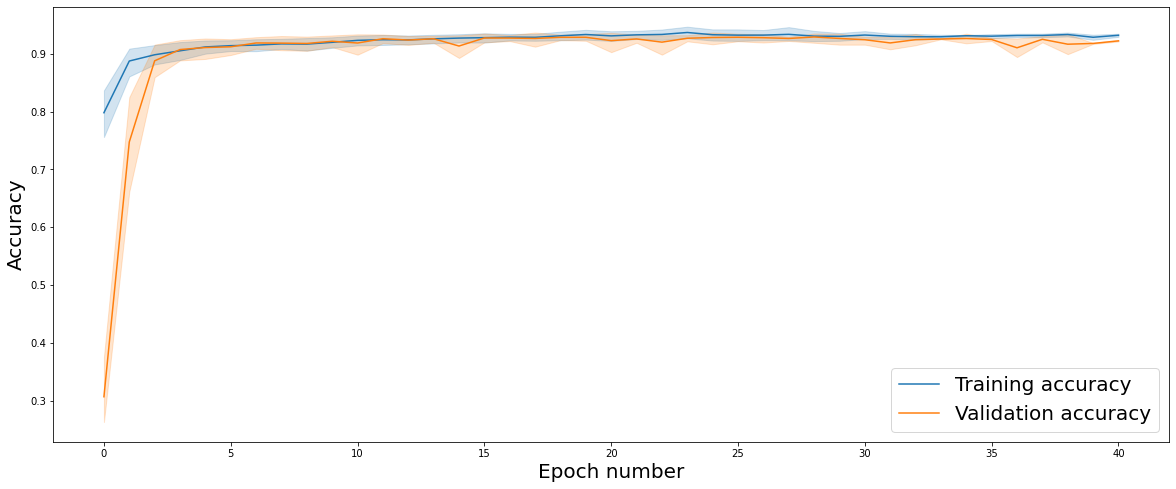

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))


sns.lineplot(data=many_metrics, x="epoch", y="accuracy", ax=ax, estimator=np.mean, ci=95, label="Training accuracy")
sns.lineplot(data=many_metrics, x="epoch", y="val_accuracy", ax=ax, estimator=np.mean, ci=95, label="Validation accuracy")
ax.set_ylabel("Accuracy", fontsize=20)
ax.set_xlabel("Epoch number", fontsize=20)
ax.legend(loc="best", prop={'size': 20})


plt.savefig(plots / "accuracy.png", transparent=True, dpi=500)

In [10]:
print("Accuracy:   min = ", min(many_metrics[many_metrics["epoch"] > 2]["val_accuracy"]), " | max = ", max(many_metrics[many_metrics["epoch"] > 2]["val_accuracy"]))
print("F1 score:   min = ", min(many_metrics[many_metrics["epoch"] > 2]["val_f1_score"]), " | max = ", max(many_metrics[many_metrics["epoch"] > 2]["val_f1_score"]))
print("Precision:   min = ", min(many_metrics[many_metrics["epoch"] > 2]["val_precision"]), " | max = ", max(many_metrics[many_metrics["epoch"] > 2]["val_precision"]))
print("Recall:   min = ", min(many_metrics[many_metrics["epoch"] > 2]["val_recall"]), " | max = ", max(many_metrics[many_metrics["epoch"] > 2]["val_recall"]))

Accuracy:   min =  0.877  | max =  0.941
F1 score:   min =  0.8777  | max =  0.941
Precision:   min =  0.877  | max =  0.941
Recall:   min =  0.8783  | max =  0.9413


In [11]:
many_metrics = metrics_all

for i in [721, 722, 724, 725]:
    path = exp_path / f"{i}/metrics/metrics_group_all.csv"
    current = pd.read_csv(path)
    many_metrics = pd.concat([many_metrics, current])

many_metrics = many_metrics[many_metrics["epoch"] < 41]

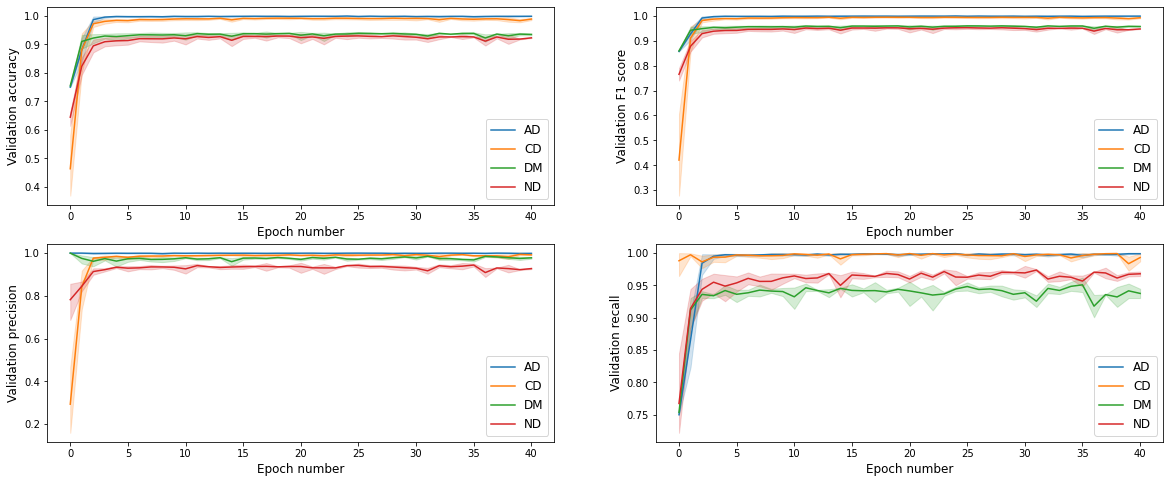

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))

sns.lineplot(data=many_metrics, x="epoch", y="val_accuracy_0", ax=axes[0][0], estimator=np.mean, ci=95, label="AD")
sns.lineplot(data=many_metrics, x="epoch", y="val_accuracy_1", ax=axes[0][0], estimator=np.mean, ci=95, label="CD")
sns.lineplot(data=many_metrics, x="epoch", y="val_accuracy_2", ax=axes[0][0], estimator=np.mean, ci=95, label="DM")
sns.lineplot(data=many_metrics, x="epoch", y="val_accuracy_3", ax=axes[0][0], estimator=np.mean, ci=95, label="ND")
axes[0][0].set_ylabel("Validation accuracy", fontsize=12)
axes[0][0].set_xlabel("Epoch number", fontsize=12)
axes[0][0].legend(loc="best", prop={'size': 12})

sns.lineplot(data=many_metrics, x="epoch", y="val_f1_score_0", ax=axes[0][1], estimator=np.mean, ci=95, label="AD")
sns.lineplot(data=many_metrics, x="epoch", y="val_f1_score_1", ax=axes[0][1], estimator=np.mean, ci=95, label="CD")
sns.lineplot(data=many_metrics, x="epoch", y="val_f1_score_2", ax=axes[0][1], estimator=np.mean, ci=95, label="DM")
sns.lineplot(data=many_metrics, x="epoch", y="val_f1_score_3", ax=axes[0][1], estimator=np.mean, ci=95, label="ND")
axes[0][1].set_ylabel("Validation F1 score", fontsize=12)
axes[0][1].set_xlabel("Epoch number", fontsize=12)
axes[0][1].legend(loc="best", prop={'size': 12})

sns.lineplot(data=many_metrics, x="epoch", y="val_precision_0", ax=axes[1][0], estimator=np.mean, ci=95, label="AD")
sns.lineplot(data=many_metrics, x="epoch", y="val_precision_1", ax=axes[1][0], estimator=np.mean, ci=95, label="CD")
sns.lineplot(data=many_metrics, x="epoch", y="val_precision_2", ax=axes[1][0], estimator=np.mean, ci=95, label="DM")
sns.lineplot(data=many_metrics, x="epoch", y="val_precision_3", ax=axes[1][0], estimator=np.mean, ci=95, label="ND")
axes[1][0].set_ylabel("Validation precision", fontsize=12)
axes[1][0].set_xlabel("Epoch number", fontsize=12)
axes[1][0].legend(loc="best", prop={'size': 12})

sns.lineplot(data=many_metrics, x="epoch", y="val_recall_0", ax=axes[1][1], estimator=np.mean, ci=95, label="AD")
sns.lineplot(data=many_metrics, x="epoch", y="val_recall_1", ax=axes[1][1], estimator=np.mean, ci=95, label="CD")
sns.lineplot(data=many_metrics, x="epoch", y="val_recall_2", ax=axes[1][1], estimator=np.mean, ci=95, label="DM")
sns.lineplot(data=many_metrics, x="epoch", y="val_recall_3", ax=axes[1][1], estimator=np.mean, ci=95, label="ND")
axes[1][1].set_ylabel("Validation recall", fontsize=12)
axes[1][1].set_xlabel("Epoch number", fontsize=12)
axes[1][1].legend(loc="best", prop={'size': 12})

plt.savefig(plots / "metrics_group.png", transparent=True, dpi=500)

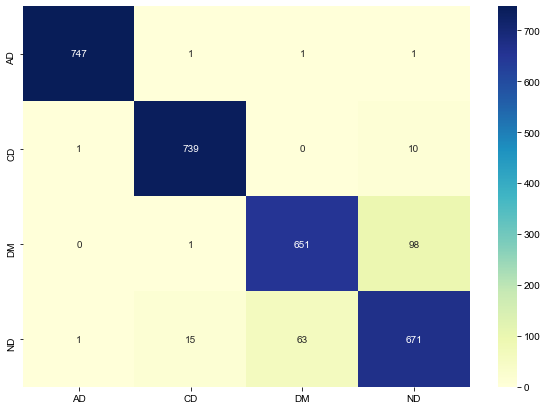

In [13]:
matrix = confusion_matrix(flat_targets.type(torch.long), flat_preds.type(torch.long))
df_cm = pd.DataFrame(matrix, index = ["AD", "CD", "DM", "ND"], columns = ["AD", "CD", "DM", "ND"])
plt.figure(figsize = (10,7))
h = sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='.5g')
sns.set(font_scale=2)



plt.savefig(plots / "cm.png", transparent=True)

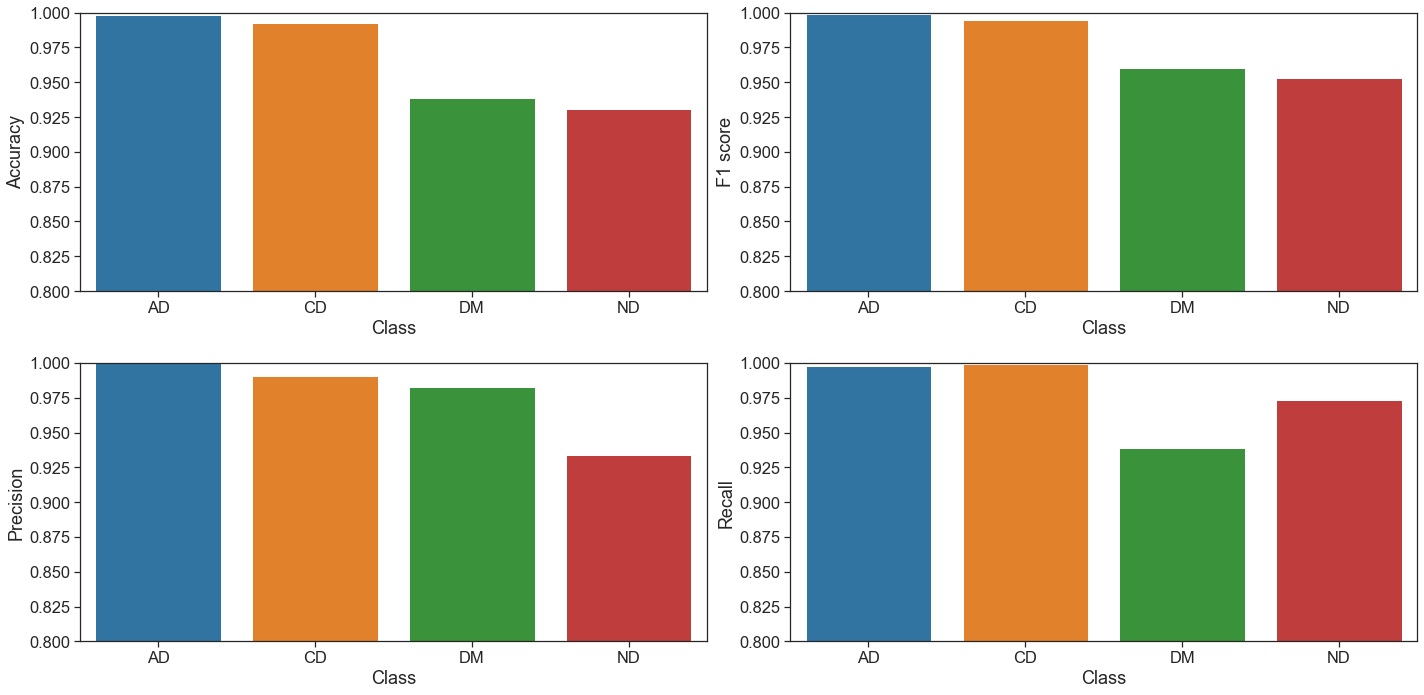

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

val_accuracy = [
    metrics_all["val_accuracy_0"].values[-10],
    metrics_all["val_accuracy_1"].values[-10], 
    metrics_all["val_accuracy_2"].values[-10], 
    metrics_all["val_accuracy_3"].values[-10]
    ]

val_precision = [
    metrics_all["val_precision_0"].values[-10],
    metrics_all["val_precision_1"].values[-10], 
    metrics_all["val_precision_2"].values[-10], 
    metrics_all["val_precision_3"].values[-10]
    ]

val_recall = [
    metrics_all["val_recall_0"].values[-10],
    metrics_all["val_recall_1"].values[-10], 
    metrics_all["val_recall_2"].values[-10], 
    metrics_all["val_recall_3"].values[-10]
    ]

val_f1_score = [
    metrics_all["val_f1_score_0"].values[-10],
    metrics_all["val_f1_score_1"].values[-10], 
    metrics_all["val_f1_score_2"].values[-10], 
    metrics_all["val_f1_score_3"].values[-10]
    ]

types = ["AD", "CD", "DM", "ND"]
numbers = [val_accuracy, val_f1_score, val_precision, val_recall, types]
numbers = [list(i) for i in zip(*numbers)]
last_scores = pd.DataFrame(numbers, columns=["Accuracy", "F1 score", "Precision", "Recall", "Class"])
sns.set(font_scale=1.5, style="ticks",  palette='tab10')

sns.barplot(x="Class", y="Accuracy", data=last_scores, capsize=.5, ax=axes[0][0])
axes[0][0].set_ylabel("Accuracy")
axes[0][0].set_xlabel("Class")
axes[0][0].set_ylim((0.8, 1))


sns.barplot(x="Class", y="F1 score", data=last_scores, capsize=.5, ax=axes[0][1])
axes[0][1].set_ylabel("F1 score")
axes[0][1].set_xlabel("Class")
axes[0][1].set_ylim((0.8, 1))

sns.barplot(x="Class", y="Precision", data=last_scores, capsize=.5, ax=axes[1][0])
axes[1][0].set_ylabel("Precision")
axes[1][0].set_xlabel("Class")
axes[1][0].set_ylim((0.8, 1))

sns.barplot(x="Class", y="Recall", data=last_scores, capsize=.5, ax=axes[1][1])
axes[1][1].set_ylabel("Recall")
axes[1][1].set_xlabel("Class")
axes[1][1].set_ylim((0.8, 1))

plt.tight_layout()
plt.savefig(plots / "last_bars.png", transparent=True, dpi=500)

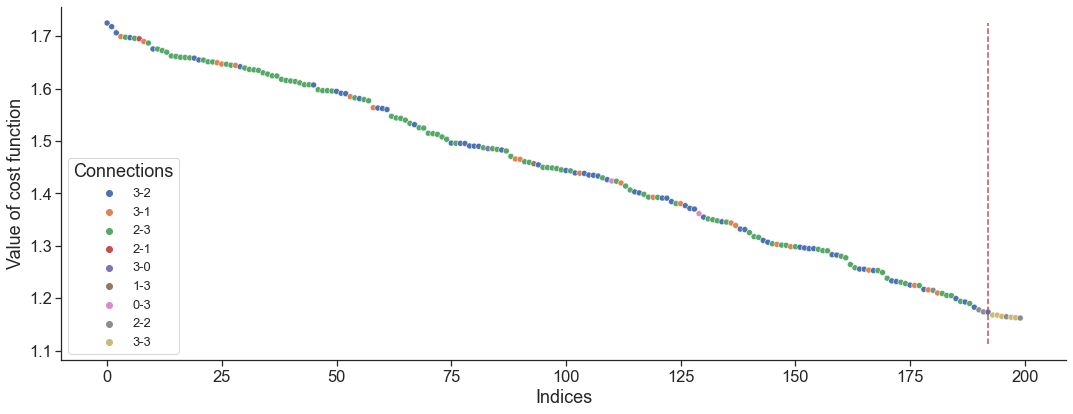

In [17]:
arrange = range(len(top_losses["target"]))
connections =[f"{str(top_losses['target'][i])}-{str(top_losses['pred'][i])}" for i in arrange]
top_losses["Connections"] = connections

sns.set(font_scale=1.5, style="ticks")
rc = {'axes.facecolor':'white', 'axes.grid' : False}
plt.rcParams.update(rc)

plt.gcf().axison = True
g = sns.scatterplot(data=top_losses, x="Unnamed: 0", y="loss", hue="Connections")
plt.plot([192, 192], [min(top_losses["loss"])-0.05, max(top_losses["loss"])], "--r")
plt.ylabel("Value of cost function")

plt.xlabel("Indices")
plt.gcf().set_size_inches(18, 6.5)
plt.legend(loc="best", prop={'size': 13}, title="Connections")
sns.despine()



plt.savefig(plots / "top_losses.png", transparent=True, dpi=500)